# Predicting sale price of flat

## Background
In Singapore, close to 80% of the population live in public housing. These are heavily subsidised by the government and as such, strict rules have been implemented to ensure the subsidies are not being misused. One such rule is that every couple is not to own more than a single subsidised property at any one time. 

## Project Motivation
I am interested in finding the potential selling price of my flat in 3 years. The main objective of this project is to provide an estimate of the expected retail price for the flat in due time. In this project, I will use a variety of regression models to make predictions on the potential selling price, rather than to take the prediction of a single model. This is to showcase the relative effectiveness of the various models for the present purpose -- predict sale price of a flat given historical transaction data.

## Data Collection
Transaction data of public flats have been dilligently chronicled [here](https://data.gov.sg/dataset/resale-flat-prices). In the final version of the project, the data will be obtained from a json object from an API call. In the initial version(s), the entire dataset will be downloaded and fed to the project in a `pandas` dataframe. Operations such as cleaning and grouping will then be performed on the dataframe itself.

### Inspiration from GovTech DSAID blog

Before going on to the project I would like to acknowledge that a huge part of this project is inspired from a [blog](https://medium.com/dsaid-govtech/wanted-data-scientists-how-we-designed-our-first-case-interview-9fd4eaa4607c) written by the [Data Science and Artificial Intelligence Division (DSAID)](https://medium.com/dsaid-govtech) of a governmental agency called GovTech. They have been pushed to the forefront since the COVID-19 pandemic hit Singapore. A familiar (and valuable) product developed by DSAID was the TraceTogether Token (and its associated App). 

For those who are unfamiliar, the token collects data via bluetooth signals, such as proximity data, duration in proximity data and places visited (We are supposed to scan for entry at the entrance of facilities like shopping malls). In the early days, this token expidited contact tracing of people exposed to others who were subsequently identified as COVID-positive, facilitating rapid isolation to supress the spread of the virus. If an individual had been shown to be in the proximity of a (subsequently identified) positive individual using data from the token, he/she will also receive a message to perform health monitoring for the requisite number of days.

After seeing the impact they have on the life on Singaporeans, after launching useful products like the TraceTogether Token and App, I thought what they are doing is very meaningful and creates impact in our everyday lives. I am sure the job there will be sufficiently motivating in and of itself.

I would want to start off with using the OneMap API to geocode the lat-long coordinates just for the fun of it. Intuitively, I do not think that should affect the selling price anymore than the 'Town' feature. Including it is purely for practice on calling information from APIs.

First, the essential libraries...

In [1]:
import pandas as pd
import numpy as np
import requests as req
from matplotlib import pyplot as plt
import json
import seaborn as sns
import re
from datetime import date
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Based on the information on [HDB API](https://data.gov.sg/dataset/resale-flat-prices), we can find the API query string as follows. We will perform our entire analysis using our entire dataset of 92,270 entries(correct as of the time of writing).


In [2]:

query_str = 'https://data.gov.sg/api/action/datastore_search?resource_id=f1765b54-a209-4718-8d38-a39237f502b3&limit=500'
response = req.get(query_str)
response.status_code

200

A side note on the response obtained from the **requests** library. A *status_code* of 200 implies that the request was successful. Otherwise the response code would have been *404 NOT FOUND*. Other possible status codes can be found [here](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes).

In [3]:
data = json.loads(response.content)
type(data)

dict

In [4]:
len(data['result']['records'])

500

## The Data
As mentioned, in the initial version(s), the data is obtained from a downloaded `.csv` file and read into a dataframe. This will be changed to an API call in the final version. After that, check that the dataset has been properly read and explore some features of the data such as the number of columns, the number of rows and the type of every column.

Even though data from the 1990's are available, they are probably outdated due to the numerous policy implementations over the years. We will only use the most recent data from 2017 onwards.

In [5]:
df = pd.read_csv("data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


### Brief explanation of columns
The various dates within the dataset may appear strage to someone not staying in Singapore. Most HDB flats come with a default 99-year lease from the government. At the end of the 99 years, the government reserve the right to repossess the land on which the flat is built for other developments. This is largely due to the lack of geographic mass of the country, which drives up the price of land and properties.

An additional note is that the `month` column contains data on when the associated flat is sold on the second-hand market. Feel free to refer to the metadata file for explanations to the context of other columns.

In [6]:
df.shape

(131560, 11)

We see that there are a total of 131560 entries, which should be enough for a small project.

### Data type of columns

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131560 entries, 0 to 131559
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                131560 non-null  object 
 1   town                 131560 non-null  object 
 2   flat_type            131560 non-null  object 
 3   block                131560 non-null  object 
 4   street_name          131560 non-null  object 
 5   storey_range         131560 non-null  object 
 6   floor_area_sqm       131560 non-null  float64
 7   flat_model           131560 non-null  object 
 8   lease_commence_date  131560 non-null  int64  
 9   remaining_lease      131560 non-null  object 
 10  resale_price         131560 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 11.0+ MB


As seen above, most of the columns are classified as `object`, even though some of them contains useful numerical data, such as `flat_type`, `storey_range` and `month`. With all else being equal, the higher the value of `storey_range`, the higher the resale price. This is due to Singaporeans' inherent preference for flats on a higher level. In this section, we will transform them into the appropriate forms.

First we extract the `year` and `month` value from the resale date, and thereafter dropping it since our model does not take in `datetime` type as a feature.

Columns such as `town`, `flat_type` and `flat_model` will be One-hot encoded as they contain information about different categories of flats, with no inherent order. Features like `storey_range` on the other land will be transformed using `OrdinalEncoder` since the value of the category has an effect on the resale price (take it from a Singaporean who has stayed here all his life!).

In [8]:
# df.rename({'month': 'sale_date'}, axis=1, inplace=True)
df['sale_date'] = pd.to_datetime(df['month'], format="%Y-%m")
df['sale_year'] = df['sale_date'].dt.year
df['sale_month'] = df['sale_date'].dt.month
df.drop(['sale_date', 'month'], axis=1, inplace=True)

### Handling `remaining_lease`
The amount of remaining lease affects the resale price in an indirect way. As mentioned, the maximum lease for HDB flats is currently at 99 years. Hence, the longer the remaining lease, the more valuable the flat is.

In [9]:
df['years_remaining'] = df['remaining_lease'].apply(lambda x: int(x.split()[0]))
df['months_remaining'] = df['remaining_lease'].apply(lambda x: int(x.split(" ")[-2]))
df.drop(["remaining_lease", "lease_commence_date"], axis=1, inplace=True)
df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,resale_price,sale_year,sale_month,years_remaining,months_remaining
0,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,232000.0,2017,1,61,4
1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,250000.0,2017,1,60,7
2,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,262000.0,2017,1,62,5
3,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,265000.0,2017,1,62,1
4,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,265000.0,2017,1,62,5


In [10]:
df['storey_range'].unique()

array(['10 TO 12', '01 TO 03', '04 TO 06', '07 TO 09', '13 TO 15',
       '19 TO 21', '22 TO 24', '16 TO 18', '34 TO 36', '28 TO 30',
       '37 TO 39', '49 TO 51', '25 TO 27', '40 TO 42', '31 TO 33',
       '46 TO 48', '43 TO 45'], dtype=object)

In [11]:
from sklearn.preprocessing import OrdinalEncoder

storey_cat = ['01 TO 03', '04 TO 06', '07 TO 09', '10 TO 12', '13 TO 15', '16 TO 18', 
                '19 TO 21', '22 TO 24', '25 TO 27', '28 TO 30', '31 TO 33', '34 TO 36',
                '37 TO 39', '40 TO 42', '43 TO 45', '46 TO 48', '49 TO 51']
oe = OrdinalEncoder(categories=[storey_cat], dtype=int)
df["storey"] = oe.fit_transform(df[["storey_range"]])

In [12]:
df.columns

Index(['town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'resale_price', 'sale_year',
       'sale_month', 'years_remaining', 'months_remaining', 'storey'],
      dtype='object')

In [13]:
ohe = OneHotEncoder(dtype=int)
ohe_features = ['town', 'flat_type', 'flat_model']
flat_type_encoding = ohe.fit_transform(df[ohe_features]).toarray()
flat_type_encoding_df = pd.DataFrame(flat_type_encoding, columns=ohe.get_feature_names())
df = df.join(flat_type_encoding_df)
df.head()

/home/ahwz84/miniconda3/envs/messy/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,resale_price,sale_year,sale_month,...,x2_Multi Generation,x2_New Generation,x2_Premium Apartment,x2_Premium Apartment Loft,x2_Premium Maisonette,x2_Simplified,x2_Standard,x2_Terrace,x2_Type S1,x2_Type S2
0,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,232000.0,2017,1,...,0,0,0,0,0,0,0,0,0,0
1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,250000.0,2017,1,...,0,1,0,0,0,0,0,0,0,0
2,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,262000.0,2017,1,...,0,1,0,0,0,0,0,0,0,0
3,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,265000.0,2017,1,...,0,1,0,0,0,0,0,0,0,0
4,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,265000.0,2017,1,...,0,1,0,0,0,0,0,0,0,0


Next we work on encoding the other columns, such as `town` and `flat_model`, once again using `OneHotEncoder`. However, `storey_range` will be encoded with `OrdinalEncoder` instead due to its ordinal nature. In general, the higher the level, the better the resale price.

### Column distribution

In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
floor_area_sqm,131560.0,97.775922,24.090810,31.0,82.0,94.0,113.0,249.0
resale_price,131560.0,469078.906158,162393.221475,140000.0,350000.0,438000.0,550088.0,1418000.0
sale_year,131560.0,2019.483278,1.622915,2017.0,2018.0,2020.0,2021.0,2022.0
sale_month,131560.0,6.488218,3.364460,1.0,4.0,7.0,9.0,12.0
years_remaining,131560.0,74.384783,13.504581,43.0,64.0,74.0,85.0,97.0
...,...,...,...,...,...,...,...,...
x2_Simplified,131560.0,0.039001,0.193599,0.0,0.0,0.0,0.0,1.0
x2_Standard,131560.0,0.028466,0.166301,0.0,0.0,0.0,0.0,1.0
x2_Terrace,131560.0,0.000578,0.024028,0.0,0.0,0.0,0.0,1.0
x2_Type S1,131560.0,0.001817,0.042584,0.0,0.0,0.0,0.0,1.0


In [15]:
df.isna().sum()

town             0
flat_type        0
block            0
street_name      0
storey_range     0
                ..
x2_Simplified    0
x2_Standard      0
x2_Terrace       0
x2_Type S1       0
x2_Type S2       0
Length: 67, dtype: int64

Under the `df.info()`, we see that most of our dataframe columns contain objects. We need to handle them one by one. Thanks to the data collection and meticulous efforts, there are no missing values in the columns, and this means we do not have to worry about filling in the *NaN*'s with mean or median values.

I am also interested whether there are any changes to the price per unit area of the flats across different areas in Singapore. It will be good to construct an additional column PSM (Price per Square Meters) just to normalise the price by the size of the flat.

In [16]:
# df['PSM'] = df['resale_price']/df['floor_area_sqm']
# df.head(10)

In [17]:
print(df['town'].unique())
df['town'].nunique()

['ANG MO KIO' 'BEDOK' 'BISHAN' 'BUKIT BATOK' 'BUKIT MERAH' 'BUKIT PANJANG'
 'BUKIT TIMAH' 'CENTRAL AREA' 'CHOA CHU KANG' 'CLEMENTI' 'GEYLANG'
 'HOUGANG' 'JURONG EAST' 'JURONG WEST' 'KALLANG/WHAMPOA' 'MARINE PARADE'
 'PASIR RIS' 'PUNGGOL' 'QUEENSTOWN' 'SEMBAWANG' 'SENGKANG' 'SERANGOON'
 'TAMPINES' 'TOA PAYOH' 'WOODLANDS' 'YISHUN']


26

We see that our data set contains around 26 unique town locations. Given the property mantra of "location, location, location", the idea will be to tag them by the first 3 digits of their postal code to turn the data in this column from `object` to `int` so as to be fed into our model.

/home/ahwz84/miniconda3/envs/messy/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Resale Price (S$M)')

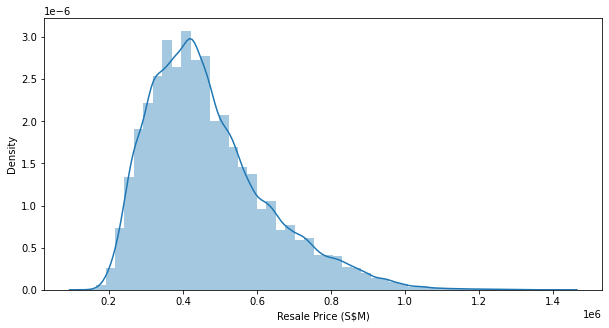

In [18]:
plt.figure(figsize=(10, 5))
sns.distplot(df['resale_price'])
plt.xlabel('Resale Price (S$M)')

Apart from finding out how the prices are distributed, we would also want to find out how the other features correlate with the resale price. This is so that we can sort the features in terms of the correlation it has with the resale price subsequently.

<AxesSubplot:>

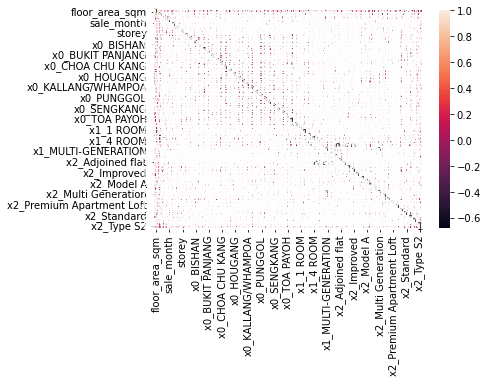

In [19]:
corrMat = df.corr()
sns.heatmap(corrMat, annot=True)

There are not many cells to plot here since the correlation can only be calculated for numerical features. Here we see that amongst the numerical features, **SIZE DOES MATTER**! 

Of course the correlation of PSM should be largely the same as floor area since it is derived as the ratio of the resale price and floor area.

Text(0, 0.5, 'Resale Price (S$M)')

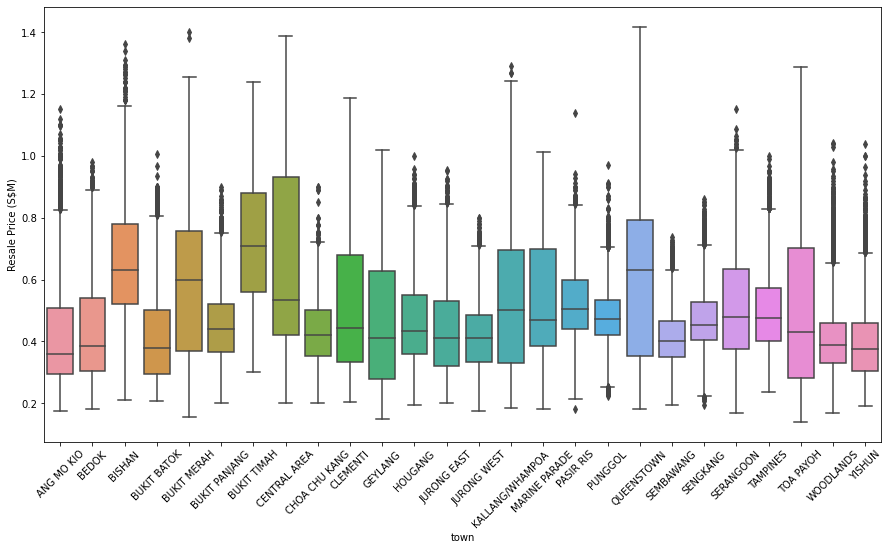

In [20]:
plt.figure(figsize=(15, 8))
ax = sns.boxplot(x=df['town'], y=df['resale_price']/1E6)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_ylabel('Resale Price (S$M)')

Now this plot looks messy since it is arranged in alphabetical order of the town the flat resides in. Let's try to order this by the median price instead and see if the plot looks tidier.

In [21]:
resale_median = df.groupby(['town']).median().reset_index()
resale_median.sort_values(by='resale_price', ascending=True, inplace=True, ignore_index=True)
resale_median['resale_price'] /= 1000000 

<AxesSubplot:xlabel='town', ylabel='resale_price'>

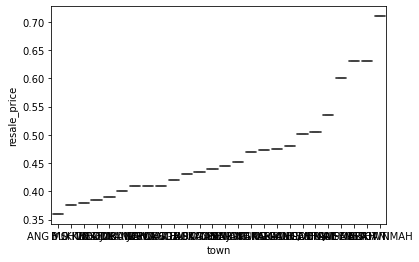

In [22]:
sns.boxplot(x='town', y='resale_price', data=resale_median)

In [23]:
df.drop(["town", "flat_type", "flat_model", "storey_range", "block", "street_name"], axis=1, inplace=True)
df.columns
# df.shape

Index(['floor_area_sqm', 'resale_price', 'sale_year', 'sale_month',
       'years_remaining', 'months_remaining', 'storey', 'x0_ANG MO KIO',
       'x0_BEDOK', 'x0_BISHAN', 'x0_BUKIT BATOK', 'x0_BUKIT MERAH',
       'x0_BUKIT PANJANG', 'x0_BUKIT TIMAH', 'x0_CENTRAL AREA',
       'x0_CHOA CHU KANG', 'x0_CLEMENTI', 'x0_GEYLANG', 'x0_HOUGANG',
       'x0_JURONG EAST', 'x0_JURONG WEST', 'x0_KALLANG/WHAMPOA',
       'x0_MARINE PARADE', 'x0_PASIR RIS', 'x0_PUNGGOL', 'x0_QUEENSTOWN',
       'x0_SEMBAWANG', 'x0_SENGKANG', 'x0_SERANGOON', 'x0_TAMPINES',
       'x0_TOA PAYOH', 'x0_WOODLANDS', 'x0_YISHUN', 'x1_1 ROOM', 'x1_2 ROOM',
       'x1_3 ROOM', 'x1_4 ROOM', 'x1_5 ROOM', 'x1_EXECUTIVE',
       'x1_MULTI-GENERATION', 'x2_2-room', 'x2_3Gen', 'x2_Adjoined flat',
       'x2_Apartment', 'x2_DBSS', 'x2_Improved', 'x2_Improved-Maisonette',
       'x2_Maisonette', 'x2_Model A', 'x2_Model A-Maisonette', 'x2_Model A2',
       'x2_Multi Generation', 'x2_New Generation', 'x2_Premium Apartment',
       

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('resale_price', axis=1), df['resale_price'], test_size=0.25, random_state=42)

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8590761518904025

In [26]:
mean_squared_error(y_test, lr.predict(X_test))

3717954574.1006207

# Concluding Thoughts
The mean_squared_error of $59.3B translates to a RMS error of around $24.3K. Given that the resale prices across all flat types ranges around $300 - 600K, this translates to an error of almost 10%. The error can be further reduced by properly setting the hyperparameters of the `LinearRegression` model, or processing the features with `PolynomialFeatures` before fitting. 

In the interim, let's recall the initial motivation for this project -- to find the projected price of my flat given the relevant features. I shall do that below, but for a 4-room flat at the "01 TO 03" storey range in Yishun, does anyone want to make a guess?

In [27]:
myflat = pd.read_csv("data/myflat.csv", header=0)
myflat.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease
0,2022-07,YISHUN,4 ROOM,342B,YISHUN RING RD,01 TO 03,92,Model A,2014,91 years 05 months


In [28]:
myflat['sale_year'] = myflat['month'].apply(lambda x: int(x.split("-")[0]))
myflat['sale_month'] = myflat['month'].apply(lambda x: int(x.split("-")[-1]))
myflat.drop('month', axis=1, inplace=True)
myflat['storey'] = oe.transform(myflat[["storey_range"]])

In [29]:
myflat_encoding = ohe.transform(myflat[ohe_features]).toarray()
myflat_encoding_df = pd.DataFrame(myflat_encoding, columns=ohe.get_feature_names())
myflat = myflat.join(myflat_encoding_df)
myflat['years_remaining'] = myflat['remaining_lease'].apply(lambda x: int(x.split()[0]))
myflat['months_remaining'] = myflat['remaining_lease'].apply(lambda x: int(x.split(" ")[-2]))
# myflat.drop(["remaining_lease", "lease_commence_date", "town", "flat_type", "flat_model", "storey_range", "block", "street_name"], axis=1, inplace=True)
myflat.head()

/home/ahwz84/miniconda3/envs/messy/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,sale_year,...,x2_Premium Apartment,x2_Premium Apartment Loft,x2_Premium Maisonette,x2_Simplified,x2_Standard,x2_Terrace,x2_Type S1,x2_Type S2,years_remaining,months_remaining
0,YISHUN,4 ROOM,342B,YISHUN RING RD,01 TO 03,92,Model A,2014,91 years 05 months,2022,...,0,0,0,0,0,0,0,0,91,5


In [30]:
myflat.drop(["remaining_lease", "lease_commence_date", "town", "flat_type", "flat_model", "storey_range", "block", "street_name"], axis=1, inplace=True)
myflat.columns

Index(['floor_area_sqm', 'sale_year', 'sale_month', 'storey', 'x0_ANG MO KIO',
       'x0_BEDOK', 'x0_BISHAN', 'x0_BUKIT BATOK', 'x0_BUKIT MERAH',
       'x0_BUKIT PANJANG', 'x0_BUKIT TIMAH', 'x0_CENTRAL AREA',
       'x0_CHOA CHU KANG', 'x0_CLEMENTI', 'x0_GEYLANG', 'x0_HOUGANG',
       'x0_JURONG EAST', 'x0_JURONG WEST', 'x0_KALLANG/WHAMPOA',
       'x0_MARINE PARADE', 'x0_PASIR RIS', 'x0_PUNGGOL', 'x0_QUEENSTOWN',
       'x0_SEMBAWANG', 'x0_SENGKANG', 'x0_SERANGOON', 'x0_TAMPINES',
       'x0_TOA PAYOH', 'x0_WOODLANDS', 'x0_YISHUN', 'x1_1 ROOM', 'x1_2 ROOM',
       'x1_3 ROOM', 'x1_4 ROOM', 'x1_5 ROOM', 'x1_EXECUTIVE',
       'x1_MULTI-GENERATION', 'x2_2-room', 'x2_3Gen', 'x2_Adjoined flat',
       'x2_Apartment', 'x2_DBSS', 'x2_Improved', 'x2_Improved-Maisonette',
       'x2_Maisonette', 'x2_Model A', 'x2_Model A-Maisonette', 'x2_Model A2',
       'x2_Multi Generation', 'x2_New Generation', 'x2_Premium Apartment',
       'x2_Premium Apartment Loft', 'x2_Premium Maisonette', 'x2_Simp

In [35]:
assert len(df.columns) == len(myflat.columns) + 1
myflat.head()

,floor_area_sqm,sale_year,sale_month,storey,x0_ANG MO KIO,x0_BEDOK,x0_BISHAN,x0_BUKIT BATOK,x0_BUKIT MERAH,x0_BUKIT PANJANG,...,x2_Premium Apartment,x2_Premium Apartment Loft,x2_Premium Maisonette,x2_Simplified,x2_Standard,x2_Terrace,x2_Type S1,x2_Type S2,years_remaining,months_remaining
0,92,2022,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,91,5
